# Conditional dependence
---
## From A *Priori* Dependence to Conditional Dependence
The relationships between causal structure and statistical dependence become particularly interesting and subtle when we look at the effects of additional observations or assumptions. Events that are statistically dependent a *priori* may become independent when we condition on some observation; this is called *screening off*. Also, events that are statistically independent a *priori* may become dependent when we condition on observations; this is known as *explaining away*. The dynamics of screening off and explaining away are extremely important for understanding patterns of inference—reasoning and learning—in probabilistic models.
## Screening off
*Screening off* refers to a pattern of statistical inference that is quite common in both scientific and intuitive reasoning. If the statistical dependence between two events A and B is only indirect, mediated strictly by one or more other events C, then conditioning on (observing) C should render A and B statistically independent. This can occur if A and B are connected by one or more causal chains, and all such chains run through the set of events C, or if C comprises all of the common causes of A and B.

For instance, let’s look again at our common cause example, this time assuming that we *already* know the value of C:

In [25]:
using Gen
include("auxilery.jl")

groupedviz (generic function with 6 methods)

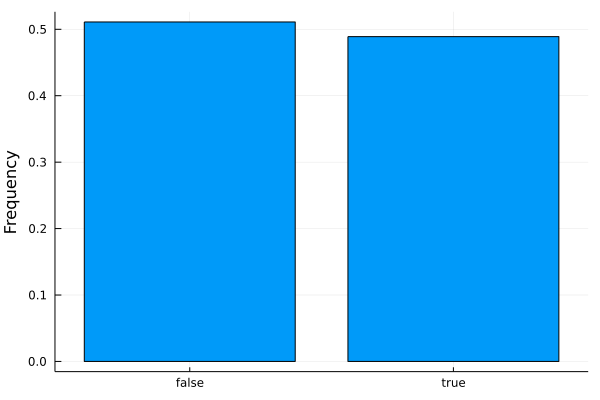

In [26]:
@gen function BcondA()
    C = @trace(bernoulli(0.5), :C)
    B = C ? @trace(bernoulli(0.5), :B) : @trace(bernoulli(0.9), :B)
    A = C ? @trace(bernoulli(0.1), :A) : @trace(bernoulli(0.4), :A)
    return B
end

ys_true = []
ys_false = []

function BcondAInfer(model,Avalue,amountOfSamples)
    observations = Gen.choicemap()
    observations[:C] = true
    observations[:A] = Avalue

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
end

for _ in 1:1000
    trace = BcondAInfer(BcondA  ,true, 1000)
    push!(ys_true, trace[:B])
    trace = BcondAInfer(BcondA ,false, 1000)
    push!(ys_false, trace[:B])
end

viz(ys_true)

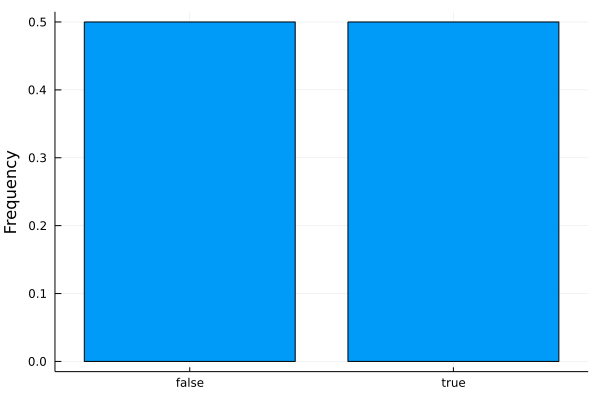

In [27]:
viz(ys_false)

We see that `A` an `B` are statistically *independent* given knowledge of `C`.

Screening off is a purely statistical phenomenon. For example, consider the the causal chain model, where A directly causes C, which in turn directly causes B. Here, when we observe C – the event that mediates an *indirect* causal relation between A and B – A and B are still causally dependent in our model of the world: it is just our beliefs about the states of A and B that become uncorrelated. There is also an analogous causal phenomenon. If we can actually manipulate or *intervene* on the causal system, and set the value of C to some known value, then A and B become both statistically and causally independent (by intervening on C, we break the causal link between A and C).

## Explaining away
“Explaining away” ([Pearl, 1988](https://scholar.google.com/scholar?q=%22Probabilistic%20reasoning%20in%20intelligent%20systems%3A%20networks%20of%20plausible%20inference%22)) refers to a complementary pattern of statistical inference which is somewhat more subtle than screening off. If two events A and B are statistically (and hence causally) independent, but they are both causes of one or more other events C, then conditioning on (observing) C can render A and B statistically dependent. Here is an example where `A` and `B` have a common *effect*:

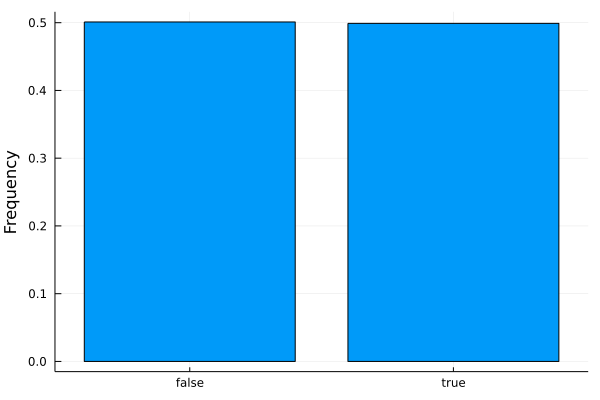

In [28]:
@gen function BcondA2()
  A = @trace(bernoulli(0.5), :A)
  B = @trace(bernoulli(0.5), :B)
  C = (A || B) ? @trace(bernoulli(0.9), :C) : @trace(bernoulli(0.2), :C)
  return B
end

ys_true = []
ys_false = []

function BcondAInfer2(model,Avalue,amountOfSamples)
  observations = Gen.choicemap()
  observations[:C] = true
  observations[:A] = Avalue

  (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
  return trace
end

for _ in 1:1000
  trace = BcondAInfer2(BcondA2  ,true, 1000)
  push!(ys_true, trace[:B])
  trace = BcondAInfer2(BcondA2 ,false, 1000)
  push!(ys_false, trace[:B])
end

viz(ys_true)

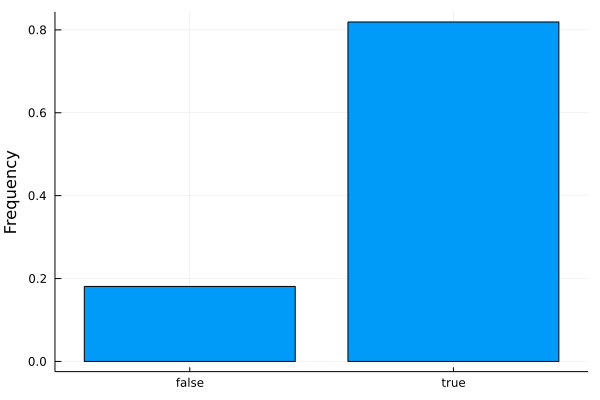

In [29]:
viz(ys_false)

As with screening off, we only induce statistical dependence from learning about `C`, not causal dependence: when we observe `C`, `A` and `B` remain causally independent in our model of the world; it is our beliefs about `A` and `B` that become correlated.

We can express the general phenomenon of explaining away with the following schematic Gen query:

```
@gen function func()
  a = ...
  b = ...
  data = f(a,b)
  return b
end

function funcInfer()
  observations = Gen.choicemap()
  observations[:data] = someVal
  observations[:a] = someOtherVal

  (trace, _) = Gen.importance_resampling(func, (), observations, 1000);
  return trace
end

```

We have defined two independent variables `a` and `b` both of which are used to define the value of our data. If we condition on `data` and `a` the posterior distribution on `b` will now be dependent on `a`: observing additional information about `a` changes our conclusions about `b`.

The most typical pattern of explaining away we see in causal reasoning is a kind of *anti-correlation*: the probabilities of two possible causes for the same effect increase when the effect is observed, but they are conditionally anti-correlated, so that observing additional evidence in favor of one cause should lower our degree of belief in the other cause. (This pattern is where the term explaining away comes from.) However, the coupling induced by conditioning on common effects depends on the nature of the interaction between the causes, it is not always an anti-correlation. Explaining away takes the form of an anti-correlation when the causes interact in a roughly disjunctive or additive form: the effect tends to happen if any cause happens; or the effect happens if the sum of some continuous influences exceeds a threshold. The following simple mathematical examples show this and other patterns.

Suppose we condition on observing the sum of two integers drawn uniformly from 0 to 9:

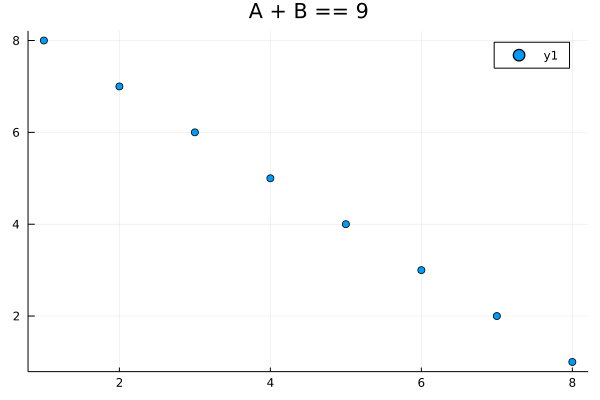

In [57]:
@gen function sumPosterior()
    A = @trace(uniform_discrete(0, 10), :A)
    B = @trace(uniform_discrete(0, 10), :B)
    return Dict(["A" => A, "B" => B])
end

##inference by enumeration function for 2 uniform_discrete variables a,b 
function enumeration_infernce(model,args)
    traces = []
    support=1:10
    for (a,b) in Iterators.product(support,support)        
        constraints  = Gen.choicemap((:A, a),(:B, b))        
        (trace, _) = generate(model, (), constraints)
        if a + b == 9 
            push!(traces, trace)
        end
    end
    return traces
end

ys=enumeration_infernce(sumPosterior,())
as=[]
bs=[]
for trace in ys
    push!(as,trace[:A])
    push!(bs,trace[:B])
end

scatter(as, bs, title = "A + B == 9")  

This gives perfect anti-correlation in conditional inferences for `A` and `B`. But suppose we instead condition on observing that `A` and `B` are equal:

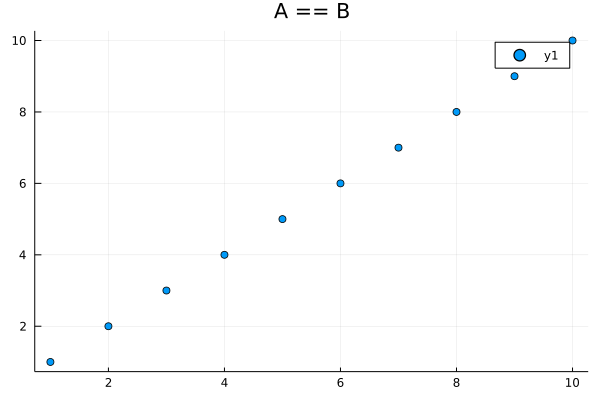

In [58]:
##inference by enumeration function for 2 uniform_discrete variables a,b 
function enumeration_infernce(model,args)
    traces = []
    support=1:10
    for (a,b) in Iterators.product(support,support)        
        constraints  = Gen.choicemap((:A, a),(:B, b))        
        (trace, _) = generate(model, (), constraints)
        if a == b 
            push!(traces, trace)
        end
    end
    return traces
end

ys=enumeration_infernce(sumPosterior,())
as=[]
bs=[]
for trace in ys
    push!(as,trace[:A])
    push!(bs,trace[:B])
end

scatter(as, bs, title = "A == B")  

Now, of course, A and B go from being independent a priori to being perfectly correlated in the conditional distribution. Try out these other conditions to see other possible patterns of conditional dependence for *a priori* independent functions:

- `Math.abs(A - B) < 2`
- `(A + B >= 9) && (A + B <= 11)`
- `Math.abs(A - B) == 3`
- `(A - B) % 10 == 3` (Note: % means “remainder when divided by…”)
- `A % 2 == B % 2`
- `A % 5 == B % 5`

# Non-monotonic Reasoning
One reason explaining away is an important phenomenon in probabilistic inference is that it is an example of *non-monotonic* reasoning. In formal logic, a theory is said to be monotonic if adding an assumption (or formula) to the theory never reduces the set of conclusions that can be drawn. Most traditional logics (e.g. First Order) are monotonic, but human reasoning does not seem to be. For instance, if I tell you that Tweety is a bird, you conclude that he can fly; if I now tell you that Tweety is an *ostrich* you retract the conclusion that he can fly. Over the years many non-monotonic logics have been introduced to model aspects of human reasoning. One of the first reasons that probabilistic reasoning with Bayesian networks was recognized as important for AI was that it could perspicuously capture these patterns of reasoning (Pearl, 1988).

Another way to think about monotonicity is by considering the trajectory of our belief in a specific proposition, as we gain additional relevant information. In traditional logic, there are only three states of belief: true, false, and unknown (when neither a proposition nor its negation can be proven). As we learn more about the world, maintaining logical consistency requires that our belief in any proposition only move from unknown to true or false. That is our “confidence” in any conclusion only increases (and only does so in one giant leap from unknown to true or false).

In a probabilistic approach, by contrast, belief comes in a whole spectrum of degrees. We can think of confidence as a measure of how far our beliefs are from a uniform distribution—how close to the extremes of 0 or 1. In probabilistic inference, unlike in traditional logic, our confidence in a proposition can both increase and decrease. Even fairly simple probabilistic models can induce complex explaining-away dynamics that lead our degree of belief in a proposition to reverse directions multiple times as observations accumulate.


## Example: Medical Diagnosis
For all folowwing examples we will use the same `medicalDist` function. The medical scenario is a great model to explore screening off and explaining away. In this model `smokes` is statistically dependent on several symptoms — `cough`, `chestPain`, and `shortnessOfBreath` — due to a causal chain between them mediated by `lungDisease`. We can see this easily by conditioning on these symptoms and looking at smokes:

In [32]:
@gen function medicalDist()
    smokes = @trace(bernoulli(0.2), :smokes)
    cold = @trace(bernoulli(0.02), :cold)

    if smokes
        lungDisease = @trace(bernoulli(1 - 0.9*0.999), :lungDisease)
    else
        lungDisease = @trace(bernoulli(0.001), :lungDisease)
    end

    if cold
        fever = @trace(bernoulli(1 - 0.7*0.99), :fever)
    else
        fever = @trace(bernoulli(0.01), :fever)
    end

    if lungDisease
        chestPain = @trace(bernoulli(1 - 0.8*0.99), :chestPain)
    else
        chestPain = @trace(bernoulli(0.01), :chestPain)
    end

    if lungDisease
        shortnessOfBreath = @trace(bernoulli(1 - 0.8*0.99), :shortnessOfBreath)
    else
        shortnessOfBreath = @trace(bernoulli(0.01), :shortnessOfBreath)
    end

    if cold
        if lungDisease
            cough = @trace(bernoulli(1 - 0.5*0.5*0.999), :cough)
        else
            cough = @trace(bernoulli(1 - 0.5*0.999), :cough)
        end
    else
        if lungDisease
            cough = @trace(bernoulli(1 - 0.5*0.999), :cough)
        else
            cough = @trace(bernoulli(0.001), :cough)
        end
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##medicalDist#287", Bool[], false)

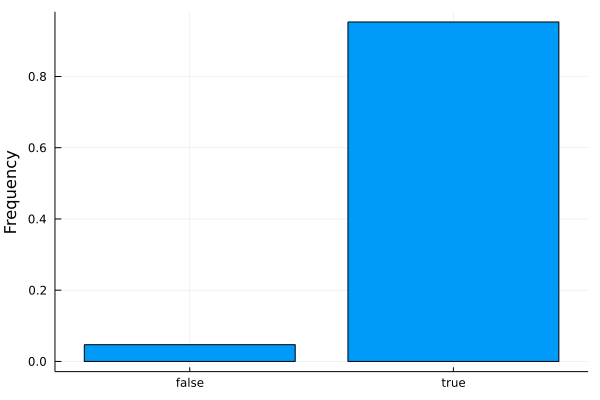

In [33]:
ys = []

function medicalDistInfer(model, amountOfSamples)
  observations = Gen.choicemap()
  observations[:cough] = true
  observations[:chestPain] = true
  observations[:shortnessOfBreath] = true

  (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
  return trace
end

for _ in 1:1000
  trace = medicalDistInfer(medicalDist, 1000)
  push!(ys, trace[:smokes])
end

viz(ys)

The conditional probability of `smokes` is much higher than the base rate, 0.2, because observing all these symptoms gives strong evidence for smoking. See how much evidence the different symptoms contribute by dropping them out of the conditioning set. (For instance, try conditioning on `cough && chestPain`, or just `cough`; you should observe the probability of `smokes` decrease as fewer symptoms are observed.)

Now, suppose we condition also on knowledge about the function that mediates these causal links: `lungDisease`. Is there still an informational dependence between these various symptoms and `smokes`? In the Inference below, try adding and removing various symptoms (`cough`, `chestPain`, `shortnessOfBreath`) but maintaining the observation `lungDisease`:


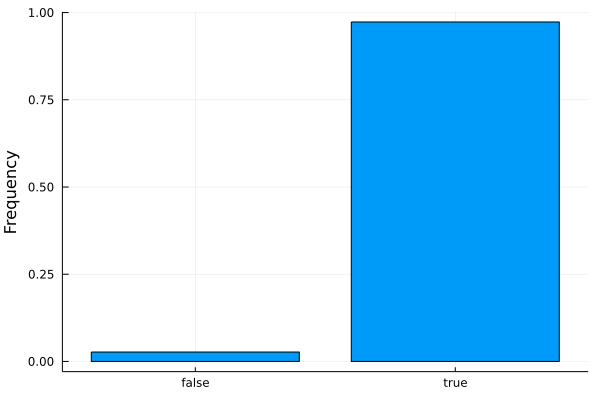

In [34]:
ys = []

function medicalDistInfer2(model, amountOfSamples)
  observations = Gen.choicemap()
  observations[:cough] = true
  observations[:chestPain] = true
  observations[:shortnessOfBreath] = true
  observations[:lungDisease] = true

  (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
  return trace
end

for _ in 1:1000
  trace = medicalDistInfer2(medicalDist, 1000)
  push!(ys, trace[:smokes])
end

viz(ys)

You should see an effect of whether the patient has lung disease on conditional inferences about smoking—a person is judged to be substantially more likely to be a smoker if they have lung disease than otherwise—but there are no separate effects of chest pain, shortness of breath, or cough over and above the evidence provided by knowing whether the patient has lung-disease. The intermediate variable lung disease *screens off* the root cause (smoking) from the more distant effects (coughing, chest pain and shortness of breath).

Here is a concrete example of explaining away in our medical scenario. Having a cold and having lung disease are a *priori* independent both causally and statistically. But because they are both causes of coughing if we observe `cough` then `cold` and `lungDisease` become statistically dependent. That is, learning something about whether a patient has `cold` or `lungDisease` will, in the presence of their common effect `cough`, convey information about the other condition. `cold` and `lungCancer` are a *priori* independent, but *conditionally dependent* given `cough`.

To illustrate, observe how the probabilities of `cold` and `lungDisease` change when we observe `cough` is true:


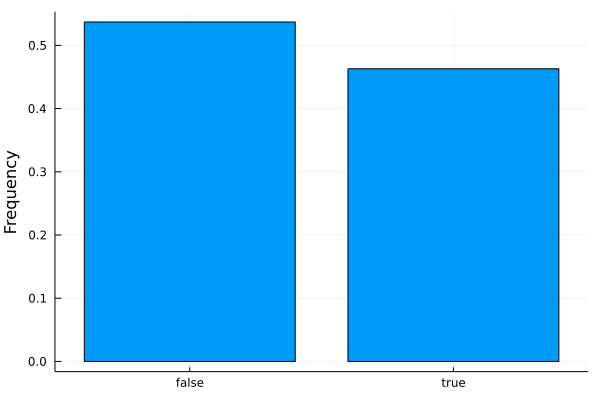

In [35]:
function medicalDistInfer3(model, amountOfSamples)
    observations = Gen.choicemap()
    observations[:cough] = true

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
  end
  
  cold_ys = []
  lungDisease_ys = []

  for _ in 1:1000
    trace = medicalDistInfer3(medicalDist, 1000)
    push!(cold_ys, trace[:cold])
    push!(lungDisease_ys, trace[:lungDisease])
  end
  
  viz(cold_ys)

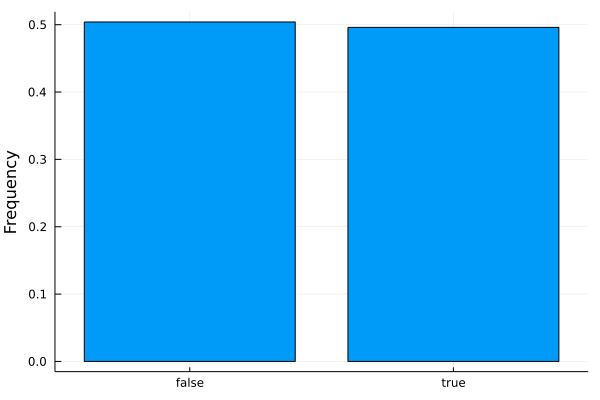

In [36]:
viz(lungDisease_ys)

Both cold and lung disease are now far more likely that their baseline probability: the probability of having a cold increases from 2% to around 50%; the probability of having lung disease also increases from 2.1% to around 50%.

Now suppose we *also* learn that the patient does *not* have a cold.

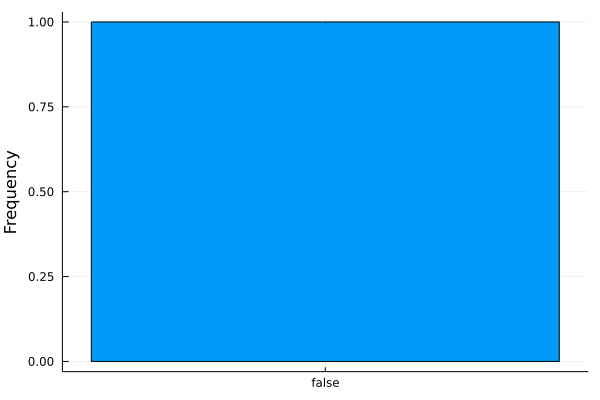

In [37]:
function medicalDistInfer4(model, amountOfSamples)
    observations = Gen.choicemap()
    observations[:cough] = true
    observations[:cold] = false

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
  end
  
  cold_ys = []
  lungDisease_ys = []

  for _ in 1:1000
    trace = medicalDistInfer4(medicalDist, 1000)
    push!(cold_ys, trace[:cold])
    push!(lungDisease_ys, trace[:lungDisease])
  end
  
  viz(cold_ys)

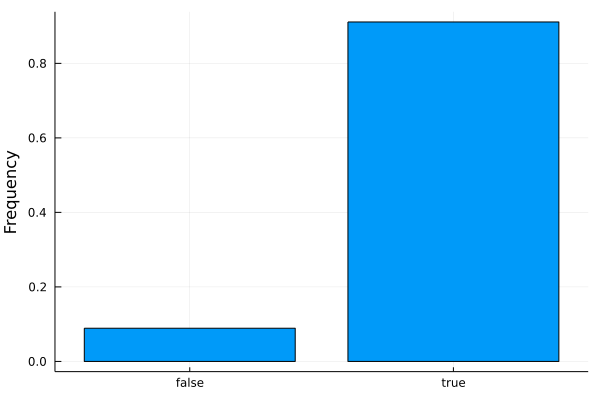

In [38]:
viz(lungDisease_ys)

The probability of having lung disease increases dramatically. If instead we had observed that the patient does have a cold, the probability of lung cancer returns to its base rate of 2.1%.

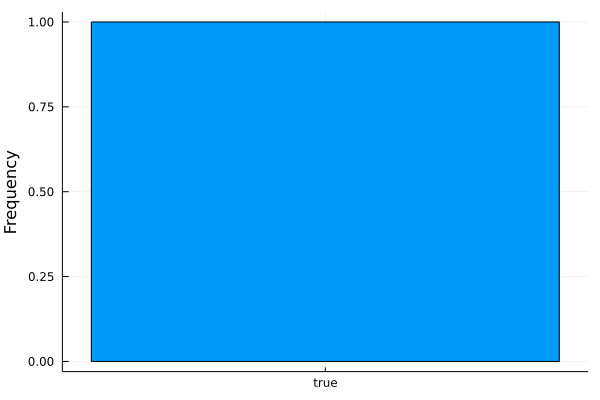

In [39]:
function medicalDistInfer5(model, amountOfSamples)
    observations = Gen.choicemap()
    observations[:cough] = true
    observations[:cold] = true

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
  end
  
  cold_ys = []
  lungDisease_ys = []

  for _ in 1:1000
    trace = medicalDistInfer5(medicalDist, 1000)
    push!(cold_ys, trace[:cold])
    push!(lungDisease_ys, trace[:lungDisease])
  end
  
  viz(cold_ys)

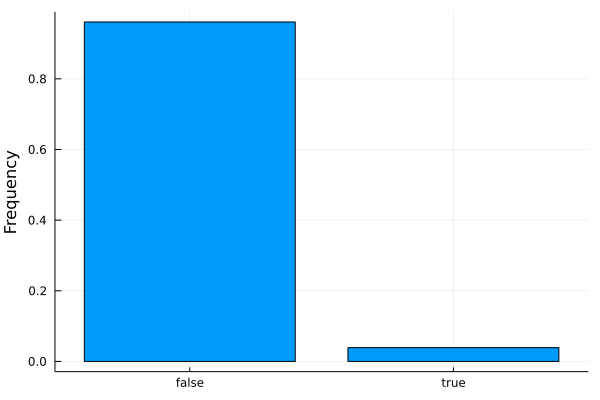

In [40]:
viz(lungDisease_ys)

This is the conditional statistical dependence between lung disease and cold, given cough: Learning that the patient does in fact have a cold “explains away” the observed cough, so the alternative of lung disease decreases to a much lower value — roughly back to its 1 in a 1000 rate in the general population. If on the other hand, we had learned that the patient does not have a cold, so the most likely alternative to lung disease is not in fact available to “explain away” the observed cough, that raises the conditional probability of lung disease dramatically. As an exercise, check that if we remove the observation of coughing, the observation of having a cold or not has no influence on our belief about lung disease; this effect is purely conditional on the observation of a common effect of these two causes.

Explaining away effects can be more indirect. Instead of observing the truth value of `cold`, a direct alternative cause of `cough`, we might simply observe another symptom that provides evidence for `cold`, such as `fever`. Compare these conditions using the above Gen program to see an “explaining away” conditional dependence in belief between `fever` and `lungDisease`.

## Example: Trait Attribution
A familiar example of rich patterns of inference comes from reasoning about the causes of students’ success and failure in the classroom. Imagine yourself in the position of an interested outside observer—a parent, another teacher, a guidance counselor or college admissions officer—in thinking about these conditional inferences. If a student doesn’t pass an exam, what can you say about why he failed? Maybe he doesn’t do his homework, maybe the exam was unfair, or maybe he was just unlucky?

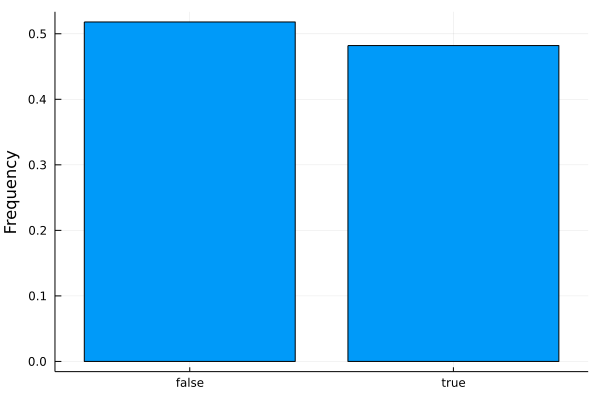

In [41]:
@gen function examPosterior()
    examFair = @trace(bernoulli(0.8), :examFair)
    doesHomework = @trace(bernoulli(0.8), :doesHomework)
    pass_p = (examFair ? (doesHomework ? 0.9 : 0.4) : (doesHomework ? 0.6 : 0.2))
    pass = @trace(bernoulli(pass_p), :pass)
end

function examPosteriorInfer(model, amountOfSamples)
    observations = Gen.choicemap()
    observations[:pass] = false

    (trace, _) = Gen.importance_resampling(model, (), observations, amountOfSamples);
    return trace
end

doesHomework_ys = []
examFair_ys = []

for _ in 1:1000
    trace = examPosteriorInfer(examPosterior, 1000)
    push!(doesHomework_ys, trace[:doesHomework])
    push!(examFair_ys, trace[:examFair])
end
  
viz(doesHomework_ys)

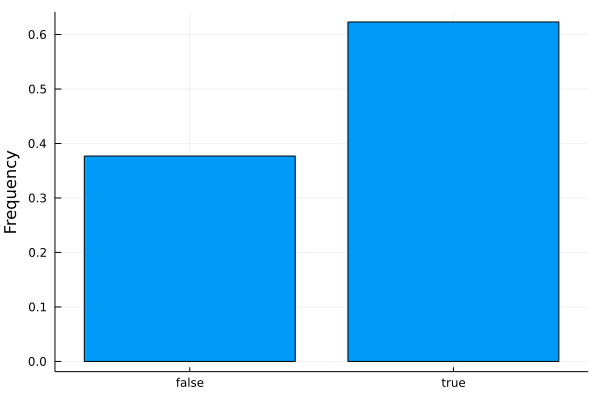

In [42]:
viz(examFair_ys)

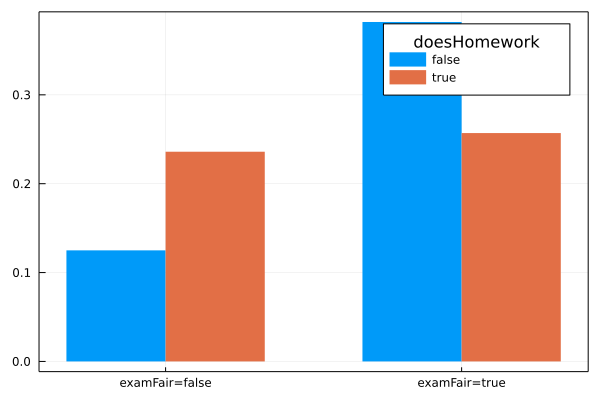

In [43]:
data = [examPosteriorInfer(examPosterior, 1000) for _ in 1:1000]
Exam_true = map(x -> x[:doesHomework],filter(x ->x[:examFair], data))
Exam_false = map(x -> x[:doesHomework],filter(x ->!x[:examFair], data))
groupedviz([Exam_true,Exam_false],["examFair=true","examFair=false","examFair=true","examFair=false"],[false,true],2,"","","","doesHomework",1000)

Now what if you have evidence from several students and several exams? We first re-write the above model to allow many students and exams:

# TODO only code, next text done:

In [44]:
# var examPosterior = Infer({method: 'enumerate'}, function() {
#   var examFair = mem(function(exam){return flip(0.8)})
#   var doesHomework = mem(function(student){return flip(0.8)})

#   var pass = function(student, exam) {
#     return flip(examFair(exam) ?
#                 (doesHomework(student) ? 0.9 : 0.4) :
#                 (doesHomework(student) ? 0.6 : 0.2))
#   };

#   condition(!pass('bill', 'exam1'))

#   return {doesHomework: doesHomework('bill'), examFair: examFair('exam1')}
# })

# viz.marginals(examPosterior)
# viz(examPosterior)

Initially we observe that Bill failed exam 1. A priori, we assume that most students do their homework and most exams are fair, but given this one observation it becomes somewhat likely that either the student didn’t study or the exam was unfair.

Notice that we have set the probabilities in the `pass` function to be asymmetric: whether a student does homework has a greater influence on passing the test than whether the exam is fair. This in turns means that when inferring the *cause* of a failed exam, the model tends to attribute it to the person property (not doing homework) over the situation property (exam being unfair). This asymmetry is an example of the *fundamental attribution bias* (Ross, 1977): we tend to attribute outcomes to personal traits rather than situations. However there are many interacting tendencies (for instance the direction of this bias switches for members of some east-asian cultures). How could you extend the model to account for these interactions?

See how conditional inferences about Bill and exam 1 change as you add in more data about this student or this exam, or additional students and exams. Try using each of the below expressions as the condition for the above inference. Try to explain the different inferences that result at each stage. What does each new piece of the larger data set contribute to your intuition about Bill and exam 1?

- `!pass('bill', 'exam1') && !pass('bill', 'exam2')`

- `!pass('bill', 'exam1') && !pass('mary', 'exam1') && !pass('tim', 'exam1')`

- `!pass('bill', 'exam1') && !pass('bill', 'exam2') && !pass('mary', 'exam1') && !pass('tim', 'exam1')`

- `!pass('bill', 'exam1') && !pass('mary', 'exam1') && pass('mary', 'exam2') && pass('mary', 'exam3') && pass('mary', 'exam4') && pass('mary', 'exam5') && !pass('tim', 'exam1') && pass('tim', 'exam2') && pass('tim', 'exam3') && pass('tim', 'exam4') && pass('tim', 'exam5')`

- `!pass('bill', 'exam1') && pass('mary', 'exam1') && pass('tim', 'exam1')`

- `!pass('bill', 'exam1') && pass('mary', 'exam1') && pass('mary', 'exam2') && pass('mary', 'exam3') && pass('mary', 'exam4') && pass('mary', 'exam5') && pass('tim', 'exam1') && pass('tim', 'exam2') && pass('tim', 'exam3') && pass('tim', 'exam4') && pass('tim', 'exam5')`

- `!pass('bill', 'exam1') && !pass('bill', 'exam2') && pass('mary', 'exam1') && pass('mary', 'exam2') && pass('mary', 'exam3') && pass('mary', 'exam4') && pass('mary', 'exam5') && pass('tim', 'exam1') && pass('tim', 'exam2') && pass('tim', 'exam3') && pass('tim', 'exam4') && pass('tim', 'exam5')`

- `!pass('bill', 'exam1') && !pass('bill', 'exam2') && pass('bill', 'exam3') && pass('bill', 'exam4') && pass('bill', 'exam5') && pass('mary', 'exam1') && pass('mary', 'exam2') && pass('mary', 'exam3') && pass('mary', 'exam4') && pass('mary', 'exam5') && pass('tim', 'exam1') && pass('tim', 'exam2') && pass('tim', 'exam3') && pass('tim', 'exam4') && pass('tim', 'exam5')`

This example is inspired by the work of Harold Kelley (and many others) on causal attribution in social settings (Kelley, 1973). Kelley identified three important dimensions of variation in the evidence, which affect the attributions people make of the cause of an outcome. These three dimensions are: Persons—is the outcome consistent across different people in the situation?; Entities—is the outcome consistent for different entities in the situation?; Time—is the outcome consistent over different episodes? These dimensions map onto the different sets of evidence we have just seen—how?

As in this example, people often have to make inferences about entities and their interactions. Such problems tend to have dense relations between the entities, leading to very challenging explaining away problems. These inferences often come very naturally to people, yet they are computationally difficult. Perhaps these are important problems that our brains have specialized somewhat to solve, or perhaps that they have evolved general solutions to these tough inferences. What do you think?

## Example: Of Blickets and Blocking
A number of researchers have explored children’s causal learning abilities by using the “blicket detector” ([Gopnik and Sobel, 2000](https://scholar.google.com/scholar?q=%22Detecting%20blickets%3A%20How%20young%20children%20use%20information%20about%20novel%20causal%20powers%20in%20categorization%20and%20induction%22)): a toy box that will light up when certain blocks, the blickets, are put on top of it. Children are shown a set of evidence and then asked which blocks are blickets. For instance, if block A makes the detector go off, it is probably a blicket. Ambiguous patterns are particularly interesting. Imagine that blocks A and B are put on the detector together, making the detector go off; it is fairly likely that A is a blicket. Now B is put on the detector alone, making the detector go off; it is now less plausible that A is a blicket. This is called “backward blocking”, and it is an example of explaining away.

We can capture this set up with a model in which each block has a persistent “blicket-ness” property, and the causal power of the block to make the machine go off depends on its blicketness. Finally, the machine goes off if any of the blocks on it is a blicket (but noisily).

In [45]:
# var blicketPosterior = Infer({method: 'enumerate'}, function() {
#   var blicket = mem(function(block) {return flip(.4)})
#   var power = function(block) {return blicket(block) ? .9 : .05}
#   var machine = function(blocks) {
#     return (blocks.length == 0 ?
#             flip(.05) :
#             flip(power(first(blocks))) || machine(rest(blocks)))
#   }
#   condition(machine(['A', 'B']))
#   //condition(machine(['B'])) //uncomment to see explaining away!
#   return blicket('A')
# });

# viz(blicketPosterior)

Try the backward blocking scenario described above. [Sobel et al. (2004)](https://scholar.google.com/scholar?q=%22Children%27s%20causal%20inferences%20from%20indirect%20evidence%3A%20Backwards%20blocking%20and%20Bayesian%20reasoning%20in%20preschoolers%22)tried this with children, finding that four year-olds perform similarly to the model: evidence that B is a blicket explains away the evidence that A and B made the detector go away.



## A Case Study in Modularity: Visual Perception of Surface Color
Visual perception is full of rich conditional inference phenomena, including both screening off and explaining away. Some very impressive demonstrations have been constructed using the perception of surface structure by mid-level vision researchers; see the work of Dan Kersten, David Knill, Ted Adelson, Bart Anderson, Ken Nakayama, among others. Most striking is when conditional inference appears to violate or alter the apparently “modular” structure of visual processing. Neuroscientists have developed an understanding of the primate visual system in which processing for different aspects of visual stimuli—color, shape, motion, stereo—appears to be at least somewhat localized in different brain regions. This view is consistent with findings by cognitive psychologists that at least in early vision, these different stimulus dimensions are not integrated but processed in a sequential, modular fashion. Yet vision is at heart about constructing a unified and coherent percept of a three-dimensional scene from the patterns of light falling on our retinas. That is, vision is causal inference on a grand scale. Its output is a rich description of the objects, surface properties and relations in the world that are not themselves directly grasped by the brain but that are the true causes of the input—low-level stimulation of the retina. Solving this problem requires integration of many appearance features across an image, and this results in the potential for massive effects of explaining away and screening off.

In vision, the luminance of a surface depends on two factors, the illumination of the surface (how much light is hitting it) and its intrinsic reflectance. The actual luminance is the product of the two factors. Thus luminance is inherently ambiguous. The visual system has to determine what proportion of the luminance is due to reflectance and what proportion is due to the illumination of the scene. This has led to a famous illusion known as the *checker shadow illusion* discovered by Ted Adelson.

![Checkershadow_illusion_small](./images/Checkershadow_illusion_small.png)

Despite appearances, in the image above both the square labeled A and the square labeled B are actually the same shade of gray. This can be seen in the figure below where they are connected by solid gray bars on either side.

![Checkershadow_proof_small](./images/Checkershadow_proof_small.png)

The presence of the cylinder is providing evidence that the illumination of square B is actually less than that of square A (because it is expected to cast a shadow). Thus we perceive square B as having higher reflectance since its luminance is identical to square A and we believe there is less light hitting it. The following program implements a simple version of this scenario “before” we see the shadow cast by the cylinder.

1.1228974781963124

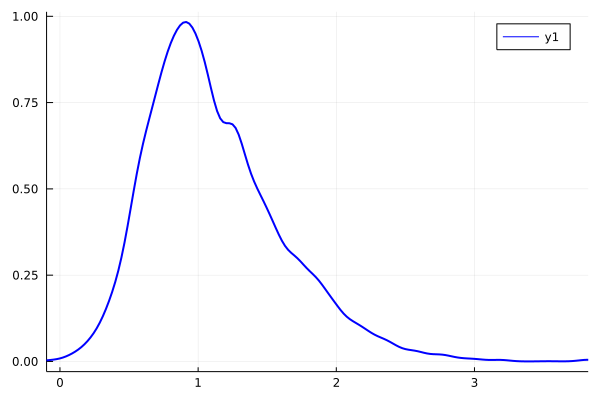

In [87]:
@gen function reflectancePosterior()
    reflectance = @trace(normal(1, 1), :reflectance)
    illumination = @trace(normal(3, 1), :illumination)
    luminance = reflectance * illumination
    observedLuminance = @trace(normal(luminance, 1), :observedLuminance)
    return reflectance
end

##infenrence function
function mhInfer(model,burn,amount_of_samples,lag)
    obeservations = choicemap()
    obeservations[:observedLuminance] = 3
    traces=[]
    (trace,_) = generate(model,(),obeservations) 
    selection = select(:reflectance, :illumination)
    for _ in 1:burn
       (trace, _) = metropolis_hastings(trace, selection, observations=obeservations)
    end
    push!(traces,trace)
    for _ in 1 :amount_of_samples
      for _ in 1:lag
        (trace, _) = metropolis_hastings(trace, selection, observations=obeservations)
      end
      push!(traces,trace)
    end
    return traces
end
traces = mhInfer(reflectancePosterior,1000,10000,1)
ret_values=map(x -> get_retval(x),traces)
print(sum(ret_values)/length(ret_values))
plot(ret_values, seriestype = :density, xlim = (minimum(ret_values),maximum(ret_values)), legend = :best, w = 2, c = :blue)

Now let’s condition on the presence of the cylinder, by conditioning on the presence of its “shadow” (i.e. gaining a noisy observation suggesting that illumination is lower than expected *a priori*):

2.1279950070684266

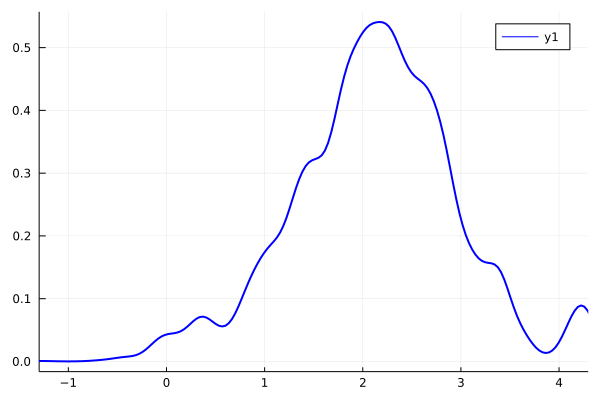

In [80]:
@gen function reflectancePosterior()
    reflectance = @trace(normal(1, 1), :reflectance)
    illumination = @trace(normal(3, 1), :illumination)
    luminance = reflectance * illumination
    observedLuminance = @trace(normal(luminance, 1), :observedLuminance)
    observedLuminance = @trace(normal(illumination, 0.1), :observedIllumination)
    return reflectance
end

##infenrence function
function mhInfer(model,burn,amount_of_samples,lag)
    obeservations = choicemap()
    obeservations[:observedLuminance] = 3
    obeservations[:observedIllumination] = 0.5
    traces=[]
    (trace,_) = generate(model,(),obeservations) 
    selection = select(:reflectance, :illumination)
    for _ in 1:burn
       (trace, _) = metropolis_hastings(trace, selection, observations=obeservations)
    end
    push!(traces,trace)
    for _ in 1 :amount_of_samples
      for _ in 1:lag
        (trace, _) = metropolis_hastings(trace, selection, observations=obeservations)
      end
      push!(traces,trace)
    end
    return traces
end
traces = mhInfer(reflectancePosterior,1000,10000,25)
ret_values=map(x -> get_retval(x),traces)
print(sum(ret_values)/length(ret_values))
plot(ret_values, seriestype = :density, xlim = (minimum(ret_values),maximum(ret_values)), legend = :best, w = 2, c = :blue)

The variables `reflectance` and `illumination` are conditionally independent in the generative model, but after we condition on `luminance` they become dependent: changing one of them affects the probability of the other. Although the model of (our knowledge of) the world has a certain kind of modularity implied by conditional independence, as soon as we start using the model to do conditional inference on some data, formerly modularly isolated variables can become dependent. This general phenomenon has important consequences for cognitive science.